In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2023-10-29 02:05:09.338143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 02:05:09.957692: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/roronoa/.conda/envs/tf/lib/python3.7/site-packages/nvidia/cudnn/lib:/home/roronoa/.conda/envs/tf/lib/:
2023-10-29 02:05:09.957786: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/roronoa/.conda/

In [2]:
df = pd.read_csv('Data/medium_data.csv')

In [3]:
df.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [4]:
df['title'] = df['title'].apply(lambda x: x.replace(u'\xa0',u' '))
df['title'] = df['title'].apply(lambda x: x.replace('\u200a',' '))

In [5]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(df['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


In [6]:
input_sequences = []
for line in df['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


In [7]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68], dtype=int32)

In [8]:
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [9]:
model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=50, verbose=1)
#print model.summary()
print(model)

2023-10-29 02:05:12.120602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-29 02:05:12.279547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-29 02:05:12.279810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-29 02:05:12.280370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/50


2023-10-29 02:05:16.703892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-10-29 02:05:16.903740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-29 02:05:16.968025: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55c3922b5330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-29 02:05:16.968054: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-10-29 02:05:16.972040: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-29 02:05:17.031254: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-29 02:

1515/1515 [==============================] - 23s 14ms/step - loss: 6.7919 - accuracy: 0.1273
Epoch 2/50
1515/1515 [==============================] - 14s 9ms/step - loss: 5.8416 - accuracy: 0.1728
Epoch 3/50
1515/1515 [==============================] - 14s 9ms/step - loss: 5.0707 - accuracy: 0.1979
Epoch 4/50
1515/1515 [==============================] - 14s 9ms/step - loss: 4.3592 - accuracy: 0.2358
Epoch 5/50
1515/1515 [==============================] - 14s 9ms/step - loss: 3.8461 - accuracy: 0.2772
Epoch 6/50
1515/1515 [==============================] - 14s 9ms/step - loss: 3.5063 - accuracy: 0.3140
Epoch 7/50
1515/1515 [==============================] - 14s 9ms/step - loss: 3.2582 - accuracy: 0.3388
Epoch 8/50
1515/1515 [==============================] - 13s 9ms/step - loss: 3.0892 - accuracy: 0.3622
Epoch 9/50
1515/1515 [==============================] - 13s 9ms/step - loss: 2.9700 - accuracy: 0.3763
Epoch 10/50
1515/1515 [==============================] - 14s 9ms/step - loss: 2.859

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

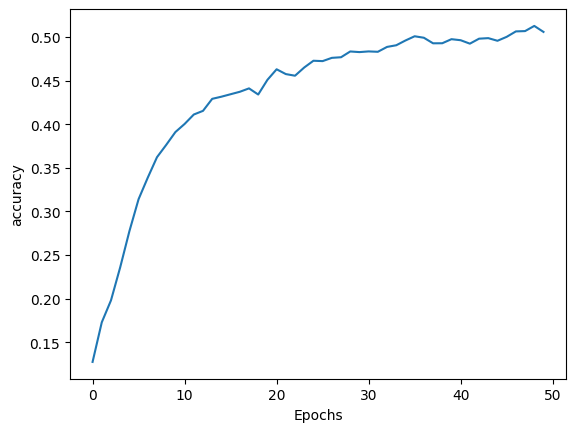

In [11]:
plot_graphs(history, 'accuracy')

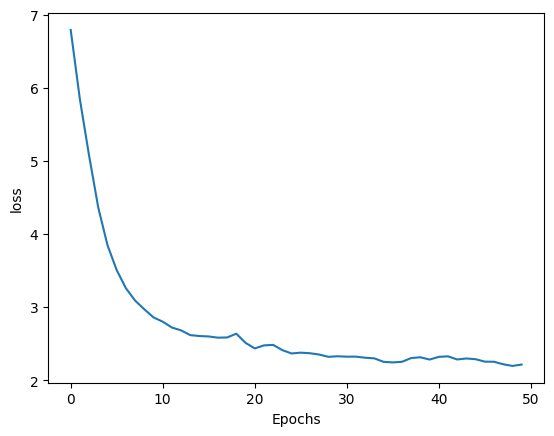

In [12]:
plot_graphs(history, 'loss')

In [13]:
import time
text = "Data"

for i in range(10):
  # tokenize
  token_text = tokenizer.texts_to_sequences([text])[0]
  # padding
  padded_token_text = pad_sequences([token_text],max_sequence_len-1, padding='pre')
  # predict
  pos = np.argmax(model.predict(padded_token_text))

  for word,index in tokenizer.word_index.items():
    if index == pos:
      text = text + " " + word
      print(text)
      time.sleep(2)

1/1 [==============================] - 0s 441ms/step
Data science
1/1 [==============================] - 0s 16ms/step
Data science productionization
1/1 [==============================] - 0s 16ms/step
Data science productionization trust
1/1 [==============================] - 0s 16ms/step
Data science productionization trust managed
1/1 [==============================] - 0s 15ms/step
Data science productionization trust managed to
1/1 [==============================] - 0s 16ms/step
Data science productionization trust managed to break
1/1 [==============================] - 0s 16ms/step
Data science productionization trust managed to break pandas
1/1 [==============================] - 0s 15ms/step
Data science productionization trust managed to break pandas analytics
1/1 [==============================] - 0s 15ms/step
Data science productionization trust managed to break pandas analytics in
1/1 [==============================] - 0s 15ms/step
Data science productionization trust managed 

In [14]:
import numpy as np

input_word = "Hands-on your data science project"

# Tokenize the input word
input_token = tokenizer.texts_to_sequences([input_word])[0]

# Padding
padded_input_token = pad_sequences([input_token], max_sequence_len - 1, padding='pre')

# Predict probabilities for all words
word_probabilities = model.predict(padded_input_token)[0]

# Get the indices of the top 3 predicted words
top_indices = np.argpartition(word_probabilities, -3)[-3:]
top_indices = top_indices[np.argsort(-word_probabilities[top_indices])]  # Sort in descending order

top_words = [word for word, index in tokenizer.word_index.items() if index in top_indices]

for word in top_words:
    print(word)


1/1 [==============================] - 0s 15ms/step
—
planning
staffing


In [15]:
import numpy as np

while True:
    input_word = input("Enter a word (or type 'exit' to quit): ")

    if input_word.lower() == 'exit':
        break

    # Tokenize the input word
    input_token = tokenizer.texts_to_sequences([input_word])[0]

    # Padding
    padded_input_token = pad_sequences([input_token], max_sequence_len - 1, padding='pre')

    # Predict probabilities for all words
    word_probabilities = model.predict(padded_input_token)[0]

    # Get the indices of the top 3 predicted words
    top_indices = np.argpartition(word_probabilities, -3)[-3:]
    top_indices = top_indices[np.argsort(-word_probabilities[top_indices])]  # Sort in descending order

    top_words = [word for word, index in tokenizer.word_index.items() if index in top_indices]

    for word in top_words:
        print(word)


Enter a word (or type 'exit' to quit): Data
1/1 [==============================] - 0s 19ms/step
science
visualization
analytics
Enter a word (or type 'exit' to quit): exit


In [16]:
import numpy as np

current_text = ""

while True:
    input_word = input("Enter a word (or type 'exit' to quit): ")

    if input_word.lower() == 'exit':
        break

    current_text += " " + input_word  # Append the current input to the existing text

    # Tokenize the updated text
    input_token = tokenizer.texts_to_sequences([current_text])[0]

    # Padding
    padded_input_token = pad_sequences([input_token], max_sequence_len - 1, padding='pre')

    # Predict probabilities for all words
    word_probabilities = model.predict(padded_input_token)[0]

    # Get the indices of the top 3 predicted words
    top_indices = np.argpartition(word_probabilities, -3)[-3:]
    top_indices = top_indices[np.argsort(-word_probabilities[top_indices])]  # Sort in descending order

    top_words = [word for word, index in tokenizer.word_index.items() if index in top_indices]

    for word in top_words:
        print(word)


Enter a word (or type 'exit' to quit): exit


In [17]:
import pickle


my_model = model 


filename = "model.pkl"

# Open the file in binary write mode ('wb')
with open(filename, 'wb') as file:
    # Serialize and write the model to the file
    pickle.dump(my_model, file)

print(f"Model saved to {filename}")


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                             